In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [100]:
#Average shots with same input param
def shot_average(df_input,df_time):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    goodness_mean=[]
    wizz_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()
    df_time_avg=pd.DataFrame(wizz_mean)
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    df_input_avg['goodness mean']=goodness_mean
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg

In [3]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

In [4]:
filename='datasets/galadriel_dataset_24_09_17.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          150073  34600.0 -17000.0 -4900000.0  1.436092
1          150074  34600.0 -17000.0 -4900000.0  1.545569
2          150075  34600.0 -17000.0 -4900000.0  1.039527
3          150076  34600.0 -17000.0 -4900000.0  1.064162
4          150077  34600.0 -17000.0 -4900000.0  1.490795
...           ...      ...      ...        ...       ...
3579       153652  35200.0  28000.0 -4000000.0  1.031162
3580       153653  35200.0  28000.0 -4000000.0  1.025235
3581       153654  35200.0  28000.0 -4000000.0  1.031162
3582       153655  35200.0  28000.0 -4000000.0  1.098433
3583       153656  35200.0  28000.0 -4000000.0  1.030238

[3584 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

### AVerage the shots with the same input param

In [90]:
df_input_avg,df_time_avg=shot_average(df_input,df_time)

In [94]:
df_time_avg

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.019038,0.030754,0.036601,0.051033,0.074304,0.062504,0.036507,0.074293,0.238725,0.593426,...,0.945013,0.547822,0.176727,0.027512,0.012283,0.020083,0.009844,0.001923,0.006419,0.006755
1,0.007292,0.004945,0.005948,0.002518,0.020279,0.077119,0.066029,0.007000,0.208194,0.703346,...,0.792928,0.363003,0.083495,0.008483,0.006511,0.002838,0.002260,0.004015,0.000867,0.000588
2,0.001919,0.011599,0.027304,0.001655,0.058470,0.148653,0.040250,0.033330,0.264011,0.641671,...,0.768540,0.246447,0.043462,0.006146,0.008353,0.021146,0.007168,0.001393,0.001959,0.001119
3,0.003675,0.028677,0.044825,0.013946,0.082421,0.207489,0.088729,0.035707,0.508923,1.000000,...,0.413096,0.110414,0.041020,0.033239,0.022389,0.018330,0.011753,0.003313,0.000463,0.000410
4,0.025752,0.036410,0.052520,0.082372,0.086947,0.058846,0.059693,0.080232,0.167092,0.520676,...,0.886147,0.437817,0.119807,0.032617,0.018998,0.017212,0.008917,0.003623,0.006003,0.004090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,0.003505,0.007780,0.005531,0.000498,0.003594,0.042263,0.184918,0.237543,0.155742,0.488626,...,0.752502,0.148579,0.023800,0.239088,0.235782,0.036834,0.025121,0.065419,0.028745,0.008504
443,0.007179,0.008442,0.004405,0.002548,0.008460,0.030631,0.129282,0.194608,0.080234,0.335083,...,0.706370,0.163847,0.014452,0.077245,0.074660,0.020117,0.013664,0.018400,0.007432,0.004879
444,0.000613,0.002883,0.010106,0.015609,0.015880,0.014290,0.069114,0.286125,0.568999,0.799526,...,0.641793,0.255520,0.064602,0.083960,0.225536,0.183455,0.030124,0.047274,0.088516,0.041162
445,0.005061,0.009711,0.007481,0.003452,0.002595,0.019746,0.126017,0.166607,0.213955,0.626702,...,0.517204,0.083416,0.055126,0.178002,0.126406,0.017481,0.032538,0.034161,0.012681,0.034735


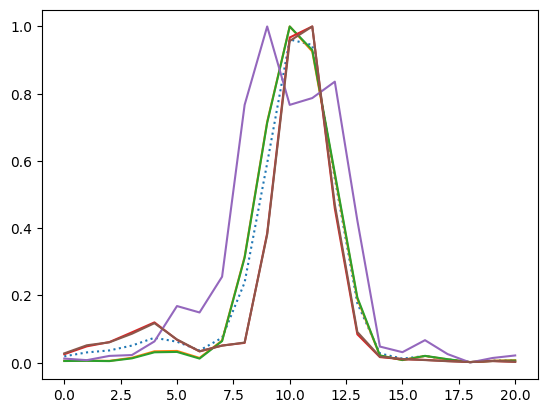

In [99]:
plt.plot(df_time_avg.iloc[0],linestyle=':')
plt.plot(df_time.iloc[0])
plt.plot(df_time.iloc[1])
plt.plot(df_time.iloc[2])
plt.plot(df_time.iloc[3])
plt.plot(df_time.iloc[4])

### Drop shots (in the avg) with bad goodness

In [108]:
df_input_reduced=df_input_avg[df_input_avg['goodness mean']>1.1]

In [111]:
good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_time_reduced=df_time_avg.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_time_reduced.reset_index(inplace=True,drop=True)

In [137]:
df_input_reduced

,order2,order3,order4,goodness mean
0,34600.0,-17000.0,-4900000.0,1.297210
1,34600.0,-17000.0,-4600000.0,1.301199
2,34600.0,-17000.0,-4300000.0,1.110099
3,34600.0,-17000.0,-4000000.0,1.251389
4,34600.0,-14000.0,-4900000.0,1.226272
...,...,...,...,...
230,35200.0,13000.0,-4600000.0,1.140089
231,35200.0,16000.0,-4900000.0,1.191342
232,35200.0,16000.0,-4600000.0,1.101391
233,35200.0,19000.0,-4900000.0,1.156019


# TRAIN THE FORWARD MODEL

In [5]:
def train_forward(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

In [6]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [7]:
forward_model_rf,df_error_forward_rf=train_forward(df_input,df_time)

In [8]:
y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

### Plot a prediction

In [9]:
def plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,
                 y_predict_forward):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=get_coef(shot_index,y_test,df_input)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_forward[shot_index],label='Prediction (Random  Forest)',linewidth=3,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict_forward[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(35, 0.6, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(35, 0.5, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

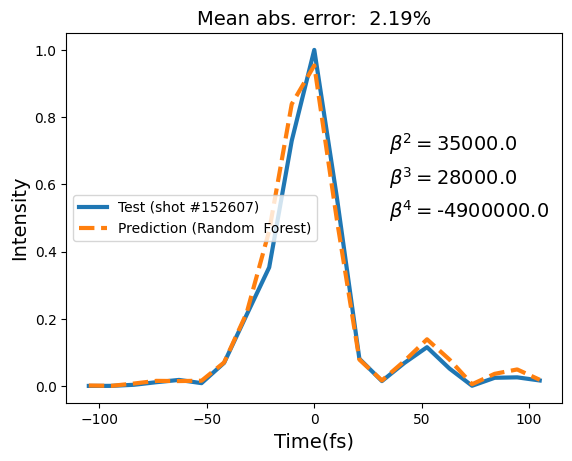

In [10]:
shot_index=308#25
plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_forward)

### TRain model with the average shots

In [101]:
#split the dataset (X:dazzler param, Y:wizzler)
X_avg_train, X_avg_test, y_avg_train, y_avg_test=models_tools.split_dataset_roundtrip(df_input_avg,df_time_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_avg_test_reset=y_avg_test.reset_index(drop=True)

In [102]:
forward_model_rf_avg,df_error_forward_rf_avg=train_forward(df_input_avg,df_time_avg)

In [103]:
y_predict_forward_avg=rf.make_rf_prediction(forward_model_rf_avg,X_avg_test)

### Train model with good goodness shots

In [113]:
#split the dataset (X:dazzler param, Y:wizzler)
X_red_train, X_red_test, y_red_train, y_red_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_time_reduced,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_red_test_reset=y_red_test.reset_index(drop=True)

In [114]:
forward_model_rf_red,df_error_forward_rf_red=train_forward(df_input_reduced,df_time_reduced)

In [115]:
y_predict_forward_red=rf.make_rf_prediction(forward_model_rf_red,X_red_test)

Text(0.5, 1.0, 'RF Model Accuracy')

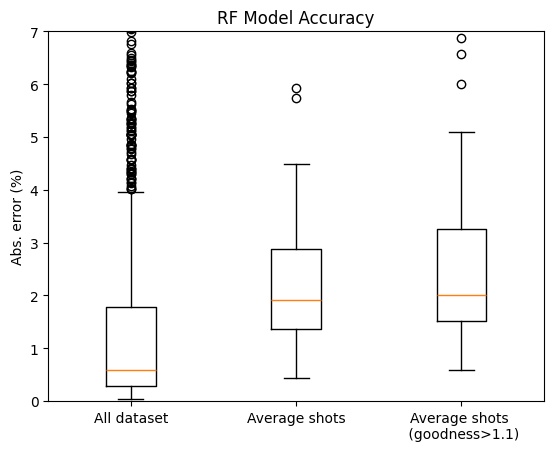

In [119]:
error_dist=[100*df_error_forward_rf,
           100*df_error_forward_rf_avg,
           100*df_error_forward_rf_red]
labels=['All dataset','Average shots','Average shots \n (goodness>1.1)']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('RF Model Accuracy')

3500 shots > 70% training   30% testing

450 shots

250 shots

## Goodness

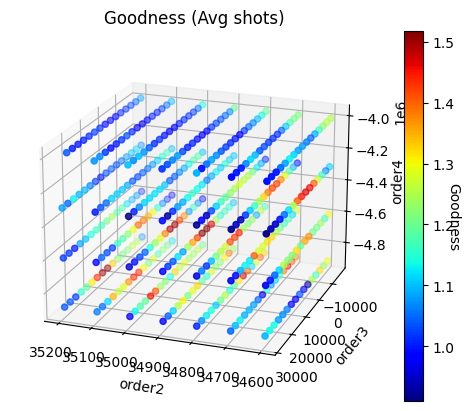

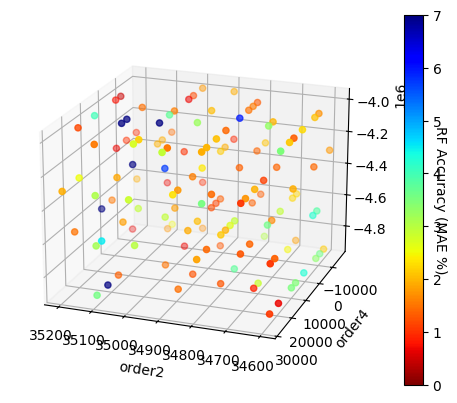

In [139]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_avg['order2'], df_input_avg['order3'], df_input_avg['order4'],c=df_input_avg['goodness mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
ax.view_init(elev=20., azim=110)
plt.title('Goodness (Avg shots)')
cbar = plt.colorbar(plot_3d)
cbar.ax.set_ylabel('Goodness', rotation=270)
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
plot_3d_2= ax2.scatter(X_avg_test['order2'], X_avg_test['order3'], X_avg_test['order4'],c=100*df_error_forward_rf_avg,
                       cmap='jet_r',vmin=0, vmax=7)
ax2.set_xlabel('order2')
ax2.set_ylabel('order3')
ax2.set_ylabel('order4')
ax2.view_init(elev=20., azim=110)
#plt.title('Goodness')
cbar2 = plt.colorbar(plot_3d_2)
cbar2.ax.set_ylabel('RF Accuracy (MAE %)', rotation=270)
plt.show()

In [122]:
df_error_forward_rf_avg

0      0.033560
1      0.020689
2      0.017554
3      0.029218
4      0.014183
         ...   
130    0.010050
131    0.057405
132    0.013683
133    0.035960
134    0.022985
Length: 135, dtype: float64

In [126]:
X_avg_test

,order2,order3,order4
12,34600.0,-8000.0,-4900000.0
19,34600.0,-5000.0,-4000000.0
259,35000.0,-17000.0,-4000000.0
289,35000.0,7000.0,-4600000.0
181,34800.0,22000.0,-4600000.0
...,...,...,...
398,35200.0,-8000.0,-4300000.0
290,35000.0,7000.0,-4300000.0
109,34700.0,16000.0,-4600000.0
93,34700.0,4000.0,-4600000.0
